In [11]:
import pydotplus

In [12]:
import pandas as pd
import numpy as np

In [13]:
train = pd.read_csv("open_data_cancer_train.csv")
train.index = train['Unnamed: 0'].values
train.drop('Unnamed: 0', axis=1, inplace=True)
#train

In [14]:
train.shape[1]

910

In [15]:
deleted_test_cancer = pd.read_csv("open_data_deleted_test_cancer.csv")
#deleted_test_cancer = pd.read_csv("deleted_test_cancer.csv")
deleted_test_cancer.index = deleted_test_cancer['Unnamed: 0'].values
deleted_test_cancer.drop('Unnamed: 0', axis=1, inplace=True)
#deleted_test_cancer

In [16]:
#ori_test = pd.read_csv("ori_test.csv")
ori_test = pd.read_csv("open_data_ori_test.csv")
ori_test.index = ori_test['Unnamed: 0'].values
ori_test.drop('Unnamed: 0', axis=1, inplace=True)
#ori_test

# XGboost

In [6]:
import xgboost as xgb
from xgboost import plot_importance

In [7]:
# 적용할 train data 생성

X_train2 = train.values
X_train2.shape
y_train_c16 = train.pop('C16')
X_train2 = train.values

In [8]:
# 적용할 test data 생성

y_test_c16 = ori_test['C16']
positive_index = np.where(y_test_c16>0)[0]
negative_index = np.where(y_test_c16<1)[0]
np.random.seed(1)
np.random.shuffle(negative_index)
pos_num = len(positive_index)
negative_index = negative_index[:pos_num]

test_sample_index = np.append(positive_index,negative_index)  

_ = deleted_test_cancer.pop('C16')
sampled_deleted_test_cancer = deleted_test_cancer.values 
sampled_deleted_test_cancer = sampled_deleted_test_cancer[test_sample_index,:]

sampled_y_test_c16 = y_test_c16.iloc[test_sample_index]

In [9]:
all_cnt = len(y_train_c16)
pos_cnt = y_train_c16.sum()
neg_cnt = all_cnt - pos_cnt
ratio_neg_pos = float(neg_cnt)/float(pos_cnt)
ratio_neg_pos

225.4469964664311

In [20]:
xgb_sk = xgb.XGBClassifier(max_depth=3,scale_pos_weight=ratio_neg_pos,gamma=5)

xgb_sk.fit(X_train2, y_train_c16)


/home/super/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=80, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=225.4469964664311,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [21]:
from sklearn import metrics
train_pred_proba= xgb_sk.predict_proba(X_train2)[:,1]
fpr_ml, tpr_ml, thresholds_ml = metrics.roc_curve(y_train_c16, train_pred_proba)
roc_auc_ml = metrics.auc(fpr_ml, tpr_ml)

In [22]:
roc_auc_ml

0.9007524386382909

In [23]:
#sampled_deleted_test_cancer

test_pred_proba= xgb_sk.predict_proba(sampled_deleted_test_cancer)[:,1]

In [24]:
(train_pred_proba>0.5 ).sum()

97494

In [25]:
fpr_ml, tpr_ml, thresholds_ml = metrics.roc_curve(sampled_y_test_c16, test_pred_proba)
roc_auc_ml = metrics.auc(fpr_ml, tpr_ml)
roc_auc_ml

0.840433432352147

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

yhat_classes = np.where(test_pred_proba<0.5,0,1)
print(recall_score(sampled_y_test_c16, yhat_classes))
print(precision_score(sampled_y_test_c16, yhat_classes))
print(f1_score(sampled_y_test_c16, yhat_classes))

0.6055900621118012
0.8125
0.6939501779359429


# Naive Bayes

In [62]:
# Naive Bayes 학습
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics

mnb = BernoulliNB(fit_prior=False)

#mnb = BernoulliNB()
mnb.fit(X_train2, y_train_c16)

y_pred = mnb.predict(sampled_deleted_test_cancer)
y_pred = pd.DataFrame(y_pred)
fpr_a, tpr_a, thresholds_a = metrics.roc_curve(sampled_y_test_c16, y_pred_ml)
roc_auc_a = metrics.auc(fpr_a, tpr_a)
roc_auc_a

0.734472049689441

In [63]:
predicted_cacer = mnb.predict(deleted_test_cancer)
fpr_nb, tpr_nb, thresholds = metrics.roc_curve(ori_test['C16'], predicted_cacer)
roc_auc_nb = metrics.auc(fpr_nb, tpr_nb)
roc_auc_nb

0.7451554976913667

In [64]:
from sklearn.metrics import f1_score

print(recall_score(sampled_y_test_c16, y_pred))
print(precision_score(sampled_y_test_c16, y_pred))
print(f1_score(sampled_y_test_c16, y_pred))

0.7142857142857143
0.7443365695792881
0.729001584786054


# Stacked autoencoder

In [17]:
train = pd.read_csv("open_data_cancer_train.csv")
train.index = train['Unnamed: 0'].values
train.drop('Unnamed: 0', axis=1, inplace=True)
#train

In [18]:
deleted_test_cancer = pd.read_csv("open_data_deleted_test_cancer.csv")
#deleted_test_cancer = pd.read_csv("deleted_test_cancer.csv")
deleted_test_cancer.index = deleted_test_cancer['Unnamed: 0'].values
deleted_test_cancer.drop('Unnamed: 0', axis=1, inplace=True)
#deleted_test_cancer

In [1]:
#import torch
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [68]:
train['C16'].sum()

2830

In [69]:
a = train.copy()
y_train_c16 = a['C16']

In [70]:
y_train_c16.sum()

2830

In [71]:
y_train_c16

0         0
1         0
2         0
3         0
4         0
         ..
712045    0
712046    0
712047    0
712048    0
712049    0
Name: C16, Length: 640845, dtype: int64

In [72]:
print(train['C16'].sum())
train['C16'] = 0
print(train['C16'].sum())

2830
0


In [73]:
y_train_c16.sum()

2830

In [74]:
X_train2 = train.values
X_train2.shape

(640845, 910)

In [75]:
train

,A02,A04,A05,A06,A08,A09,A31,A41,A42,A46,...,Z90,Z92,Z93,Z94,Z95,Z96,Z97,Z98,Z99,Z_
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
712046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
712047,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
712048,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
import tensorflow as tf
from tensorflow.keras.regularizers import l1, l2, l1_l2

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    regularize = 1e-3 #1e-4:l1 # 1e-2하면 NN에서 loss가 nan으로 나온다.

    stacked_sparse_encoder = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(910,)),
        keras.layers.Dropout(0.5),  
        keras.layers.Dense(400, activation='selu'),
        keras.layers.Dense(100, activation='selu'),
        keras.layers.Dense(20, activation='sigmoid', activity_regularizer=l1(regularize)) 
    ])

    stacked_sparse_decoder = keras.models.Sequential([
        keras.layers.Dense(100, activation='selu'), 
        keras.layers.Dense(400, activation='selu'),
        keras.layers.Dense(910, activation='sigmoid')
    ])
    
    in0 = tf.keras.Input((910,),name="in0")
    m = tf.keras.Model(inputs=in0, outputs=stacked_sparse_decoder(stacked_sparse_encoder(in0)))
    tf.keras.utils.plot_model(m, show_shapes=True, expand_nested=True)

    stacked_sparse_ae = keras.models.Sequential([stacked_sparse_encoder, stacked_sparse_decoder])

    stacked_sparse_ae.compile(loss = tf.keras.losses.BinaryCrossentropy(),
    #stacked_sparse_ae.compile(loss = 'mse',
    #stacked_sparse_ae.compile(loss = 'binary_crossentropy',
    #stacked_sparse_ae.compile(loss = my_custom_loss,
                       optimizer='adam')
    #history = stacked_sparse_ae.fit(X_train2, X_train2.astype(float),
    #                                batch_size=1024, epochs = 100)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [4]:
import keras
#import pydotplus
from keras.utils.vis_utils import model_to_dot
#keras.utils.vis_utils.pydot = pydot
plot_model(stacked_sparse_ae, to_file='model.png')

ModuleNotFoundError: No module named 'keras'

In [5]:
tf.keras.utils.plot_model(
    stacked_sparse_ae, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

TypeError: plot_model() got an unexpected keyword argument 'show_dtype'

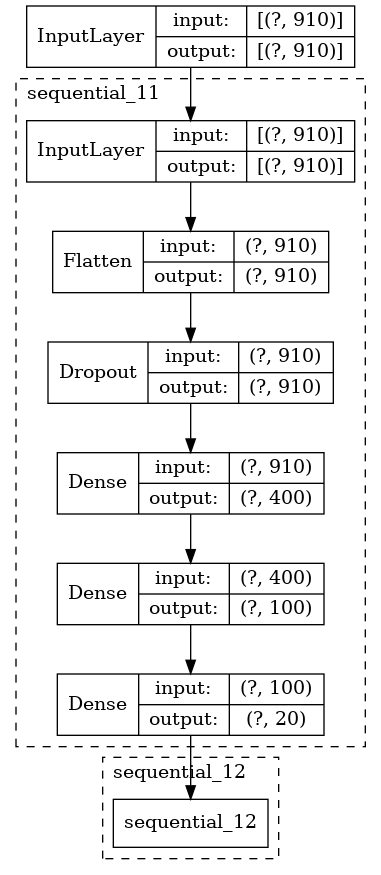

In [60]:
from tensorflow.keras.utils import plot_model
plot_model(m, to_file='model_shapes.png', show_shapes=True, show_layer_names=False, expand_nested=True)


#plot_model(stacked_sparse_ae, show_shapes=True, show_layer_names=True)

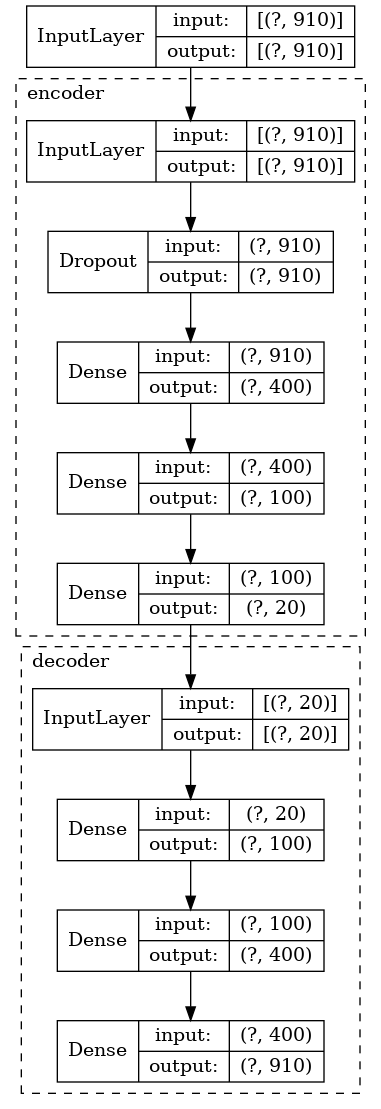

In [2]:
inn = tf.keras.Input((910,),name="in1")
hidden = tf.keras.layers.Dropout(.5)(inn)
d1 = tf.keras.layers.Dense(400, name="d1")(hidden)
d2 = tf.keras.layers.Dense(100, name="d2")(d1)
d3 = tf.keras.layers.Dense(20, name="d3")(d2)
m1 = tf.keras.Model(inputs=inn, outputs=d3, name="encoder")

in2_1 = tf.keras.Input((20,),name="in2_1")
in2_2 = tf.keras.layers.Dense(100,name="in2_2")(in2_1)
in2_3 = tf.keras.layers.Dense(400,name="in2_3")(in2_2)
in2_4 = tf.keras.layers.Dense(910,name="in2_4")(in2_3)
#in2_2 = tf.keras.Input((1,),name="in2_2")
m2 = tf.keras.Model(inputs=[in2_1],outputs=[in2_4],name="decoder")


#        keras.layers.Dropout(0.5),  
#        keras.layers.Dense(400, activation='selu'),
#        keras.layers.Dense(100, activation='selu'),
#        keras.layers.Dense(20, activation='sigmoid', activity_regularizer=l1(regularize)) 


# combined model
in0 = tf.keras.Input((910,),name="in0")
m = tf.keras.Model(inputs=in0, outputs=m2(m1(in0)))
tf.keras.utils.plot_model(m, show_shapes=True, expand_nested=True, show_layer_names=False)

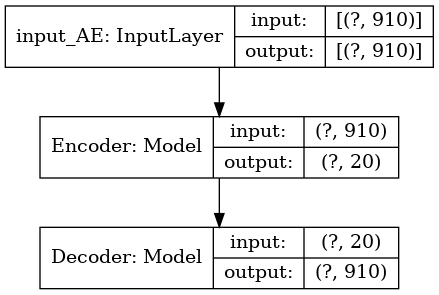

In [22]:
inn = tf.keras.Input((910,),name="in1")
hidden = tf.keras.layers.Dropout(.5)(inn)
d1 = tf.keras.layers.Dense(400, name="d1")(hidden)
d2 = tf.keras.layers.Dense(100, name="d2")(d1)
d3 = tf.keras.layers.Dense(20, name="d3")(d2)
m1 = tf.keras.Model(inputs=inn, outputs=d3, name="Encoder")

in2_1 = tf.keras.Input((20,),name="in2_1")
in2_2 = tf.keras.layers.Dense(100,name="in2_2")(in2_1)
in2_3 = tf.keras.layers.Dense(400,name="in2_3")(in2_2)
in2_4 = tf.keras.layers.Dense(910,name="in2_4")(in2_3)
#in2_2 = tf.keras.Input((1,),name="in2_2")
m2 = tf.keras.Model(inputs=[in2_1],outputs=[in2_4],name="Decoder")


#        keras.layers.Dropout(0.5),  
#        keras.layers.Dense(400, activation='selu'),
#        keras.layers.Dense(100, activation='selu'),
#        keras.layers.Dense(20, activation='sigmoid', activity_regularizer=l1(regularize)) 

in3_1 = tf.keras.layers.Input( (20,),name="in3_1")
in3_2 = tf.keras.layers.Dense(1,name="output")(in3_1)
m3 = tf.keras.Model(inputs=[in3_1],outputs=[in3_2],name="Decoder")

#m2 = tf.keras.Model(inputs=[in2_1,in2_2],outputs=[in2_1 + in2_2],name="model2")


# combined model
in0 = tf.keras.Input((910,),name="input_AE")
m = tf.keras.Model(inputs=in0, outputs= [m2(m1(in0)), m2(m1(in0))])
tf.keras.utils.plot_model(m, show_shapes=True, expand_nested=False, show_layer_names=True)

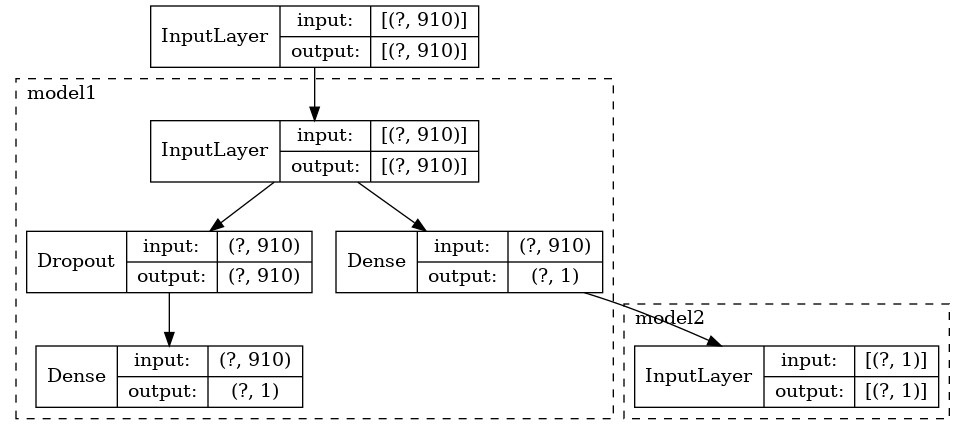

In [6]:
inn = tf.keras.Input((910,),name="in1")
hidden = tf.keras.layers.Dropout(.2)(inn)
d1 = tf.keras.layers.Dense(1, name="d1")(hidden)
d2 = tf.keras.layers.Dense(1, name="d2")(inn)
m1 = tf.keras.Model(inputs=inn, outputs=[d1,d2], name="model1")
in2_1 = tf.keras.Input((1,),name="in2_1")
m2 = tf.keras.Model(inputs=[in2_1],outputs=[in2_1],name="model2")

# combined model
in0 = tf.keras.Input((910,),name="in0")
m = tf.keras.Model(inputs=in0, outputs=m2(m1(in0)))
tf.keras.utils.plot_model(m, show_shapes=True, expand_nested=True, show_layer_names=False)

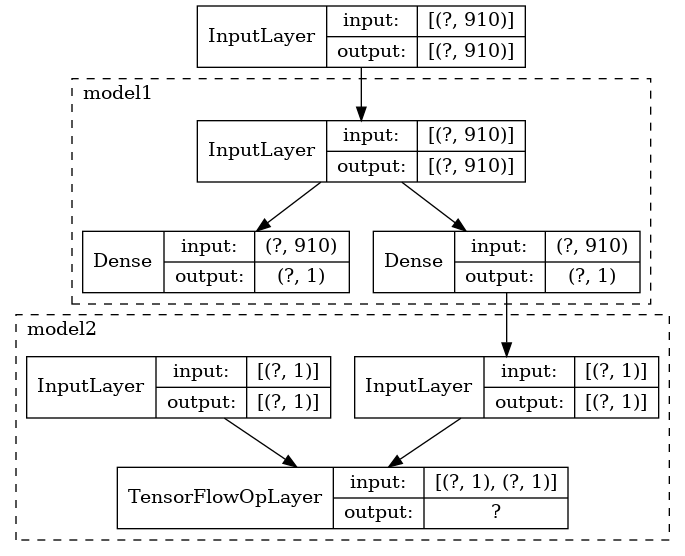

In [28]:
inn = tf.keras.Input((910,),name="in1")
d1 = tf.keras.layers.Dense(1, name="d1")(inn)
d2 = tf.keras.layers.Dense(1, name="d2")(inn)
m1 = tf.keras.Model(inputs=inn, outputs=[d1,d2], name="model1")
in2_1 = tf.keras.Input((1,),name="in2_1")
in2_2 = tf.keras.Input((1,),name="in2_2")
m2 = tf.keras.Model(inputs=[in2_1,in2_2],outputs=[in2_1 + in2_2],name="model2")

# combined model
in0 = tf.keras.Input((910,),name="in0")
m = tf.keras.Model(inputs=in0, outputs=m2(m1(in0)))
tf.keras.utils.plot_model(m, show_shapes=True, expand_nested=True, show_layer_names=False)

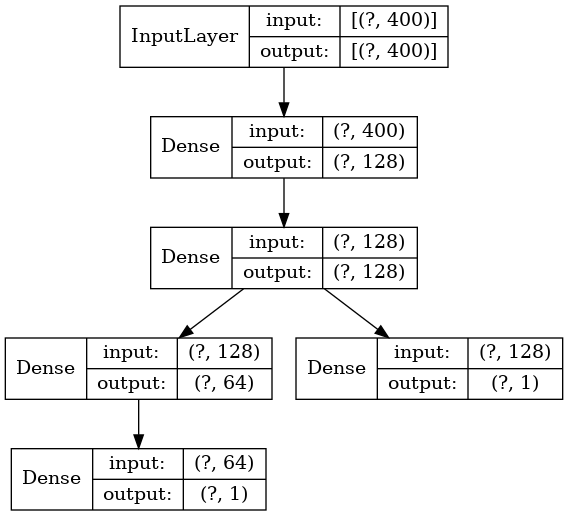

In [42]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
# define model layers
input_layer = Input(shape=(910),)
first_dense = Dense(400, activation='relu')(input_layer)
second_dense = Dense(100, activation='relu')(first_dense)
# define y1 output and third dense
y1_output = Dense(1, name='y1_output')(second_dense)
third_dense = Dense(64, activation='relu')(second_dense)
# define y2 output
y2_output = Dense(1, name='y2_output')(third_dense)
# define model with the input layer and a list of output layers


m1 = Model(inputs=input_layer, outputs=[y1_output,y2_output], name="model1")
#m1 = Model(inputs=input_layer, outputs=[y1_output,y2_output], name="model1")


#model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

tf.keras.utils.plot_model(m1, show_shapes=True, expand_nested=True, show_layer_names=False)

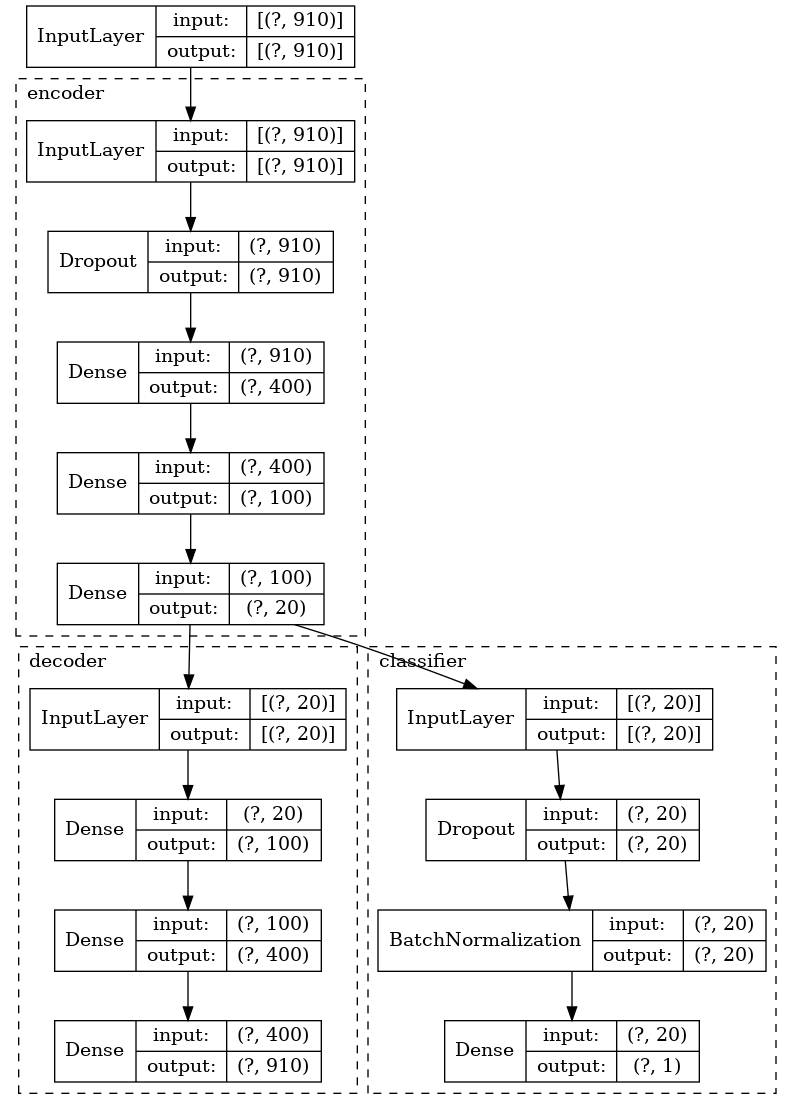

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
# define model layers
input_layer = Input(shape=(910),)
dp = tf.keras.layers.Dropout(.5)(input_layer)
first_dense = Dense(400, activation='relu')(dp)
second_dense = Dense(100, activation='relu')(first_dense)
third_dense = Dense(20, activation='relu')(second_dense)

m_encoder = Model(inputs=[input_layer], outputs = [third_dense], name ='encoder')


inc_1 = tf.keras.Input((20,))
hidden = tf.keras.layers.Dropout(.5)(inc_1)
hidden2 = tf.keras.layers.BatchNormalization()(hidden)
out_c = tf.keras.layers.Dense(1,name="out")(hidden2)

m_classifier = Model(inputs = [inc_1], outputs = [out_c], name='classifier')


in2_1 = tf.keras.Input((20,),name="in2_1")
in2_2 = tf.keras.layers.Dense(100,name="in2_2")(in2_1)
in2_3 = tf.keras.layers.Dense(400,name="in2_3")(in2_2)
in2_4 = tf.keras.layers.Dense(910,name="in2_4")(in2_3)
#in2_2 = tf.keras.Input((1,),name="in2_2")
m_decoder = tf.keras.Model(inputs=[in2_1],outputs=[in2_4],name="decoder")



#m_classifier= tf.keras.Model(inputs=[second_dense],outputs=[out_c],name="decoder")

## define y1 output and third dense
#s_dense = Dense(16, activation='relu')(second_dense)
#y1_output = Dense(1, name='y1_output')(s_dense)


#third_dense = Dense(32, activation='relu')(second_dense)
## define y2 output
#y2_output = Dense(1, name='y2_output')(third_dense)
## define model with the input layer and a list of output layers


in0 = tf.keras.Input((910,),name="in0")
m1 = tf.keras.Model(inputs=in0, outputs=[m_decoder(m_encoder(in0)),m_classifier(m_encoder(in0))]   )


#m1 = Model(inputs = input_layer, outputs = m_decoder(m_encoder(input_layer)))
#m1 = Model(inputs=input_layer, outputs=[y1_output,y2_output], name="model1")
#m1 = Model(inputs=input_layer, outputs=[y1_output,y2_output], name="model1")


#model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

tf.keras.utils.plot_model(m1, show_shapes=True, expand_nested=True, show_layer_names=False)

In [77]:
X_train2.shape

(640845, 910)

In [78]:
history = stacked_sparse_ae.fit(X_train2, X_train2.astype(float),
                                #class_weight = class_weights,
                                batch_size=1024*8, epochs = 40)

Epoch 1/40
79/79 [==============================] - 12s 113ms/step - loss: 0.2219
Epoch 2/40
79/79 [==============================] - 9s 110ms/step - loss: 0.0496
Epoch 3/40
79/79 [==============================] - 9s 109ms/step - loss: 0.0471
Epoch 4/40
79/79 [==============================] - 9s 108ms/step - loss: 0.0452
Epoch 5/40
79/79 [==============================] - 8s 106ms/step - loss: 0.0445
Epoch 6/40
79/79 [==============================] - 8s 107ms/step - loss: 0.0438
Epoch 7/40
79/79 [==============================] - 8s 105ms/step - loss: 0.0431
Epoch 8/40
79/79 [==============================] - 8s 103ms/step - loss: 0.0426
Epoch 9/40
79/79 [==============================] - 8s 104ms/step - loss: 0.0413
Epoch 10/40
79/79 [==============================] - 8s 106ms/step - loss: 0.0403
Epoch 11/40
79/79 [==============================] - 8s 104ms/step - loss: 0.0400
Epoch 12/40
79/79 [==============================] - 8s 105ms/step - loss: 0.0398
Epoch 13/40
79/79 [=====

In [79]:
deleted_test_cancer.shape

(71205, 910)

In [80]:
(deleted_test_cancer.C16).sum()

0

In [81]:
cancer_predict = stacked_sparse_ae.predict(deleted_test_cancer)

In [82]:
from sklearn import metrics
cancer_predict = stacked_sparse_ae.predict(deleted_test_cancer)
predicted_cacer = pd.DataFrame(cancer_predict)
predicted_cacer.columns = ori_test.columns

fpr, tpr, thresholds = metrics.roc_curve(ori_test['C16'], predicted_cacer['C16'])
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.7203138660041921

In [83]:
processed = stacked_sparse_encoder.predict(X_train2)

In [84]:
pd.DataFrame(X_train2).shape

(640845, 910)

In [85]:
train.shape

(640845, 910)

In [86]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    
    regularize = 1e-4 #1e-4:l1 # 1e-2하면 NN에서 loss가 nan으로 나온다.


    model = tf.keras.models.Sequential([
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(input_shape=(processed.shape[1],)),
    tf.keras.layers.Dense(1,
                          #activity_regularizer=l1(regularize),
                          kernel_initializer='he_normal',
                          activation='sigmoid')
])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [87]:
total = y_train_c16.shape[0]
pos = y_train_c16.sum()
neg = total - pos

weight_for_0 = (1 / neg)*(total)/2.0
weight_for_1 = (1 / pos)*(total)/2.0
#weight_for_0 = 1#(1 / neg)*(total)/2.0
#weight_for_1 = 500#(1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.502217816195544, 1: 113.22349823321554}

In [88]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
             metrics=['accuracy'])#하면 0.813로 나온다.

history = model.fit(processed, y_train_c16, batch_size=1024*8, epochs=50,
                   class_weight=class_weight)

Epoch 1/50
79/79 [==============================] - 3s 8ms/step - loss: 0.6551 - accuracy: 0.4261
Epoch 2/50
79/79 [==============================] - 1s 8ms/step - loss: 0.6386 - accuracy: 0.5156
Epoch 3/50
79/79 [==============================] - 1s 7ms/step - loss: 0.6454 - accuracy: 0.4775
Epoch 4/50
79/79 [==============================] - 1s 7ms/step - loss: 0.6490 - accuracy: 0.4822
Epoch 5/50
79/79 [==============================] - 1s 7ms/step - loss: 0.6426 - accuracy: 0.5079
Epoch 6/50
79/79 [==============================] - 1s 7ms/step - loss: 0.6530 - accuracy: 0.4812
Epoch 7/50
79/79 [==============================] - 1s 7ms/step - loss: 0.6369 - accuracy: 0.4971
Epoch 8/50
79/79 [==============================] - 1s 7ms/step - loss: 0.6479 - accuracy: 0.4859
Epoch 9/50
79/79 [==============================] - 1s 7ms/step - loss: 0.6492 - accuracy: 0.5030
Epoch 10/50
79/79 [==============================] - 1s 7ms/step - loss: 0.6490 - accuracy: 0.4833
Epoch 11/50
79/79 [

In [89]:
y_test_c16 = ori_test['C16']

In [90]:
positive_index = np.where(y_test_c16>0)[0]
negative_index = np.where(y_test_c16<1)[0]
np.random.seed(1)
np.random.shuffle(negative_index)
pos_num = len(positive_index)
negative_index = negative_index[:pos_num]

test_sample_index = np.append(positive_index,negative_index)  

sampled_deleted_test_cancer = deleted_test_cancer.values 
sampled_deleted_test_cancer = sampled_deleted_test_cancer[test_sample_index,:]

sampled_y_test_c16 = y_test_c16.iloc[test_sample_index]

In [91]:
test_processed = stacked_sparse_encoder.predict(sampled_deleted_test_cancer)

In [92]:
# metrics:accuracy로 재확인
from sklearn import metrics
cancer_predict2 = model.predict(test_processed)
predicted_cacer2 = pd.DataFrame(cancer_predict2)
stacked_ae_fpr2, stacked_ae_tpr2, stacked_ae_thresholds2 = metrics.roc_curve(sampled_y_test_c16, predicted_cacer2)
stacked_ae_roc_auc2 = metrics.auc(stacked_ae_fpr2, stacked_ae_tpr2)
stacked_ae_roc_auc2

0.7799756953821226

In [93]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

yhat_classes = np.where(cancer_predict2<0.5,0,1)
print(recall_score(sampled_y_test_c16, yhat_classes))
print(precision_score(sampled_y_test_c16, yhat_classes))
print(f1_score(sampled_y_test_c16, yhat_classes))

0.7888198757763976
0.699724517906336
0.7416058394160584


In [94]:
# 샘플링X
from sklearn import metrics
cancer_predict = stacked_sparse_encoder.predict(deleted_test_cancer)
cancer_predict3 = model.predict(cancer_predict)
cancer_predict2 = np.where(cancer_predict3<0.5,0,1)
#cancer_predict2 = cancer_predict3

#from sklearn import metrics
#cancer_predict = stacked_sparse_ae.predict(deleted_test_cancer)
predicted_cacer = pd.DataFrame(cancer_predict2)
#predicted_cacer.columns = ori_test.columns

fpr, tpr, thresholds = metrics.roc_curve(ori_test['C16'], predicted_cacer)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.7164688236577061

# Proposed Model

## weightned binary cross entropy Loss 함수 (시도)

In [20]:
train = pd.read_csv("open_data_cancer_train.csv")
train.index = train['Unnamed: 0'].values
train.drop('Unnamed: 0', axis=1, inplace=True)
#train

In [21]:
deleted_test_cancer = pd.read_csv("open_data_deleted_test_cancer.csv")
#deleted_test_cancer = pd.read_csv("deleted_test_cancer.csv")
deleted_test_cancer.index = deleted_test_cancer['Unnamed: 0'].values
deleted_test_cancer.drop('Unnamed: 0', axis=1, inplace=True)
#deleted_test_cancer

In [22]:
a = train.copy()
y_train_c16 = a['C16']
y_train_c16.sum()

2830

In [23]:
print(train['C16'].sum())
train['C16'] = 0
print(train['C16'].sum())

2830
0


In [24]:
y_train_c16.sum()

2830

In [25]:
X_train2 = train.values
X_train2.shape

(640845, 910)

In [26]:
# Class Weights 만들기
from sklearn.utils import class_weight 
class_weight_balanced = class_weight.compute_class_weight('balanced',np.unique(ori_test.columns),ori_test.columns)
class_weight_balanced = dict(enumerate(class_weight_balanced))

/home/super/anaconda3/envs/tsf2_ys_temp/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=['A02' 'A04' 'A05' 'A06' 'A08' 'A09' 'A31' 'A41' 'A42' 'A46' 'A48' 'A49'
 'A69' 'A74' 'A87' 'A_' 'B00' 'B02' 'B07' 'B08' 'B09' 'B17' 'B18' 'B19'
 'B25' 'B27' 'B30' 'B33' 'B34' 'B35' 'B36' 'B37' 'B44' 'B48' 'B49' 'B83'
 'B85' 'B86' 'B88' 'B95' 'B96' 'B97' 'B98' 'B_' 'C02' 'C09' 'C11' 'C15'
 'C16' 'C17' 'C18' 'C19' 'C20' 'C22' 'C23' 'C24' 'C25' 'C32' 'C34' 'C37'
 'C41' 'C43' 'C44' 'C49' 'C64' 'C65' 'C66' 'C67' 'C71' 'C73' 'C77' 'C78'
 'C79' 'C80' 'C83' 'C85' 'C88' 'C90' 'C91' 'C92' 'C95' 'C_' 'D00' 'D01'
 'D04' 'D09' 'D10' 'D11' 'D12' 'D13' 'D14' 'D15' 'D16' 'D17' 'D18' 'D21'
 'D22' 'D23' 'D30' 'D31' 'D32' 'D33' 'D34' 'D35' 'D36' 'D37' 'D38' 'D39'
 'D41' 'D43' 'D44' 'D45' 'D46' 'D47' 'D48' 'D50' 'D51' 'D52' 'D53' 'D59'
 'D61' 'D62' 'D63' 'D64' 'D68' 'D69' 'D70' 'D72' 'D73' 'D75' 'D86' 'D89'
 'D_' 'E02' 'E03' 'E04' 'E05' 'E06' 'E07' 'E10' 'E11' 'E12' 'E13' 'E14'


In [27]:
total = y_train_c16.shape[0]
pos = y_train_c16.sum()
neg = total - pos

weight_for_0 = (1 / neg)*(total)/2.0
weight_for_1 = (1 / pos)*(total)/2.0
#weight_for_0 = 1#(1 / neg)*(total)/2.0
#weight_for_1 = 500#(1 / pos)*(total)/2.0

class_weight_aux = {0: weight_for_0, 1: weight_for_1}
class_weight_aux



#weights = class_weight.compute_class_weight('balanced',
#                                            np.unique(y_train_c16),
#                                            y_train_c16)
#weights = {i : weights[i] for i in range(2)}
#weights


{0: 0.502217816195544, 1: 113.22349823321554}

In [28]:
#import torch
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.regularizers import l1, l2, l1_l2



# mirror

In [29]:
def weighted_bincrossentropy(true, pred, weight_zero = class_weight_aux[0], weight_one = class_weight_aux[1]):
    """
    Calculates weighted binary cross entropy. The weights are fixed.
        
    This can be useful for unbalanced catagories.
    
    Adjust the weights here depending on what is required.
    
    For example if there are 10x as many positive classes as negative classes,
        if you adjust weight_zero = 1.0, weight_one = 0.1, then false positives 
        will be penalize 10 times as much as false negatives.
    """
  
    # calculate the binary cross entropy
    bin_crossentropy = keras.backend.binary_crossentropy(true, pred)
    
    # apply the weights
    weights = true * weight_one + (1. - true) * weight_zero
    weighted_bin_crossentropy = weights * bin_crossentropy 

    return keras.backend.mean(weighted_bin_crossentropy)

In [39]:
import tensorflow as tf
from tensorflow.keras.regularizers import l1, l2, l1_l2

#train.shape[1]: 910

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    regularize = 1e-3 #1e-4:l1 # 1e-2하면 NN에서 loss가 nan으로 나온다.

    input_A = keras.Input(shape=(train.shape[1],))
    e_h1 = keras.layers.Dropout(0.5)(input_A)
    e_h2 = keras.layers.Dense(400, activation='selu')(e_h1)
    e_h3 = keras.layers.Dense(100, activation='selu')(e_h2)
    e_h4 = keras.layers.Dense(20, activation='sigmoid', activity_regularizer=l1(regularize))(e_h3)
#    stacked_sparse_encoder = keras.models.Sequential([
#        keras.layers.Flatten(input_shape=(1181,)),
#        keras.layers.Dropout(0.5),
#        keras.layers.Dense(400, activation='selu'),
#        keras.layers.Dense(100, activation='selu'),
#        keras.layers.Dense(20, activation='sigmoid', activity_regularizer=l1(regularize))
#    ])
    d_h1 = keras.layers.Dense(100, activation='selu')(e_h4)
    d_h2 = keras.layers.Dense(400, activation='selu')(d_h1)
    output = keras.layers.Dense(train.shape[1], activation='sigmoid', name='ae')(d_h2)
#    stacked_sparse_decoder = keras.models.Sequential([
#        keras.layers.Dense(100, activation='selu'), 
#        keras.layers.Dense(400, activation='selu'),
#        keras.layers.Dense(1181, activation='sigmoid')
#    ])
#    stacked_sparse_ae = keras.models.Sequential([stacked_sparse_encoder, stacked_sparse_decoder])
    
    regularize = 1e-4 #1e-4:l1 # 1e-2하면 NN에서 loss가 nan으로 나온다.
    h1 = tf.keras.layers.Dropout(0.5)(e_h4)
    h2 = tf.keras.layers.BatchNormalization()(h1)
#    h3 = tf.keras.layers.Dense(10, activation='selu')(h2)
    output_aux = keras.layers.Dense(1, kernel_initializer='he_normal',activation='sigmoid', name='predictions')(h2)

#    aux_classifier = tf.keras.models.Sequential([
#        stacked_sparse_encoder
#        tf.keras.layers.Dropout(0.5),
#        tf.keras.layers.BatchNormalization(input_shape=(processed.shape[1],)),
#        tf.keras.layers.Dense(1,
#                          #activity_regularizer=l1(regularize),
#                          kernel_initializer='he_normal',
#                          activation='sigmoid')

    model = keras.Model(inputs = input_A, outputs = [output, output_aux])
#    model = keras.Model(inputs = input_A, outputs = output_aux )
    model.summary()
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss = ["binary_crossentropy",weighted_bincrossentropy],
                  #loss_weights = [.8,.2],
                  loss_weights = [.8,.2],
                  optimizer=opt)

#    model.compile(loss = 'binary_crossentropy',
#                  optimizer=opt)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 910)]        0                                            
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 910)          0           input_2[0][0]                    
___________________________________________________

In [41]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_shapzzzz.png', show_shapes=True)

AttributeError: 'ListWrapper' object has no attribute 'name'

In [32]:
history = model.fit( X_train2, [X_train2.astype(float),y_train_c16.astype(float) ],
                                #class_weight = class_weight_aux,#{'output':class_weight_balanced, 'output_aux':class_weight_aux} ,
                                batch_size=1024*8, epochs = 60)

#history = model.fit( X_train2, y_train_c16 , 
#                                class_weight = class_weight_aux,#{'output':class_weight_balanced, 'output_aux':class_weight_aux} ,
#                                batch_size=1024*8, epochs = 60)

Epoch 1/60
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm

79/79 [==============================] - 2s 23ms/step - loss: 0.1359 - dense_12_loss: 0.5137 - dense_11_loss: 0.0401
Epoch 55/60
79/79 [==============================] - 2s 22ms/step - loss: 0.1362 - dense_12_loss: 0.5154 - dense_11_loss: 0.0401
Epoch 56/60
79/79 [==============================] - 2s 22ms/step - loss: 0.1372 - dense_12_loss: 0.5202 - dense_11_loss: 0.0401
Epoch 57/60
79/79 [==============================] - 2s 23ms/step - loss: 0.1355 - dense_12_loss: 0.5122 - dense_11_loss: 0.0400
Epoch 58/60
79/79 [==============================] - 2s 26ms/step - loss: 0.1359 - dense_12_loss: 0.5142 - dense_11_loss: 0.0400
Epoch 59/60
79/79 [==============================] - 2s 25ms/step - loss: 0.1371 - dense_12_loss: 0.5202 - dense_11_loss: 0.0400
Epoch 60/60
79/79 [==============================] - 2s 29ms/step - loss: 0.1364 - dense_12_loss: 0.5170 - dense_11_loss: 0.0400


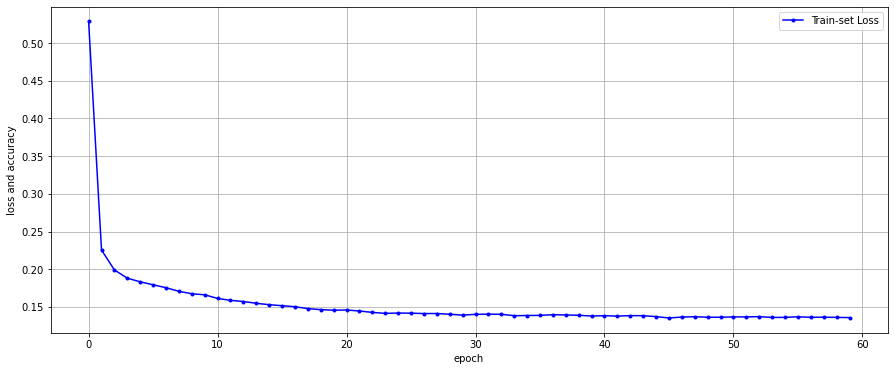

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

x_len = np.arange(len(history.history['loss']))

#y_vloss = history.history['val_loss']
y_loss = history.history['loss']
#y_vacc = history.history['val_accuracy']
#y_acc = history.history['accuracy']

x_len = np.arange(len(y_loss))
#plt.plot(x_len, y_vloss, marker='.', c='blue', linestyle='--', label="Validation-set Loss")
#plt.plot(x_len, y_vacc, marker='.', c='red', linestyle='--', label="Validation-set Accuracy")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")
#plt.plot(x_len, y_acc, marker='.', c='red', label="Train-set Accuracy")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss and accuracy')
plt.show()

In [108]:
deleted_test_cancer.shape

(71205, 910)

In [109]:
from sklearn import metrics
cancer_predict = model.predict(deleted_test_cancer)
#cancer_predict = cancer_predict[0] ####????????

In [110]:
cancer_predict = cancer_predict[1]
cancer_predict

array([[0.46639594],
       [0.16514334],
       [0.2668057 ],
       ...,
       [0.46784014],
       [0.39075026],
       [0.58778995]], dtype=float32)

In [111]:
#from sklearn import metrics
#cancer_predict = stacked_sparse_ae.predict(deleted_test_cancer)
predicted_cacer = pd.DataFrame(cancer_predict)
#predicted_cacer.columns = ori_test.columns

fpr, tpr, thresholds = metrics.roc_curve(ori_test['C16'], predicted_cacer)
roc_auc = metrics.auc(fpr, tpr)
#all_test = []
#all_test.append(roc_auc)
roc_auc

0.8564696718755245

In [112]:
y_pred_cancer = np.where(cancer_predict<0.5,0,1)
y_pred_cancer

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [113]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

print('recall: ', recall_score(ori_test['C16'].values, y_pred_cancer))
print('precision:', precision_score(ori_test['C16'].values, y_pred_cancer))
print('f1_score: ', f1_score(ori_test['C16'].values, y_pred_cancer))

recall:  0.7857142857142857
precision: 0.013825136612021859
f1_score:  0.02717216195897326


In [114]:
#del stacked_sparse_encoder
#del stacked_sparse_decoder
#del stacked_sparse_ae
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()


## test data

In [115]:
y_test_c16 = ori_test['C16']

deleted_test_cancer.C16.sum()

0

In [116]:
### C16 all same value for bias 
deleted_test_cancer.C16 = 0#0.3#pos/total

In [117]:
deleted_test_cancer.C16

107772    0
596653    0
398815    0
260904    0
6756      0
         ..
78616     0
60844     0
288431    0
91365     0
406288    0
Name: C16, Length: 71205, dtype: int64

In [118]:
positive_index = np.where(y_test_c16>0)[0]
negative_index = np.where(y_test_c16<1)[0]
np.random.seed(1)
np.random.shuffle(negative_index)
pos_num = len(positive_index)
negative_index = negative_index[:pos_num]

test_sample_index = np.append(positive_index,negative_index)  

sampled_deleted_test_cancer = deleted_test_cancer.values 
sampled_deleted_test_cancer = sampled_deleted_test_cancer[test_sample_index,:]

sampled_y_test_c16 = y_test_c16.iloc[test_sample_index]

In [119]:
sampled_y_test_c16.sum()

322

In [120]:
# metrics:accuracy로 재확인
from sklearn import metrics
cancer_predict2 = model.predict(sampled_deleted_test_cancer)[1]
predicted_cacer2 = pd.DataFrame(cancer_predict2)
proposed_model_fpr2, proposed_model_tpr2, proposed_model_thresholds2 = metrics.roc_curve(sampled_y_test_c16, predicted_cacer2)
#sampled_test = []
proposed_model_roc_auc2 = metrics.auc(proposed_model_fpr2, proposed_model_tpr2)
#sampled_test.append(roc_auc2)
proposed_model_roc_auc2

0.8615794143744455

In [121]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
#from sklearn.metrics import top_k_accuracy_score
yhat_classes = np.where(cancer_predict2<0.5,0,1)

In [122]:
#recall_results = []
#precision_results = []
#f1_score_results = []

yhat_classes.sum()

333

In [123]:
#recall_results.append(recall_score(sampled_y_test_c16, yhat_classes))
recall_score(sampled_y_test_c16, yhat_classes)

0.7857142857142857

In [124]:
#precision_results.append(precision_score(sampled_y_test_c16, yhat_classes))
precision_score(sampled_y_test_c16, yhat_classes)

0.7597597597597597

In [125]:
#f1_score_results.append(f1_score(sampled_y_test_c16, yhat_classes))
f1_score(sampled_y_test_c16, yhat_classes)

0.7725190839694657

In [126]:
#len(f1_score_results)

In [127]:
#del stacked_sparse_encoder
#del stacked_sparse_decoder
#del model
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()



# Ablation Study

In [54]:
sampled_deleted_test_cancer.shape

(644, 910)

In [56]:



sampled_y_test_c16 = y_test_c16.iloc[test_sample_index]


for i in range(910):
    sampled_deleted_test_cancer = deleted_test_cancer.values 
    sampled_deleted_test_cancer = sampled_deleted_test_cancer[test_sample_index,:]
    sampled_deleted_test_cancer[:,i]  = 0
    
    
    cancer_predict2 = model.predict(sampled_deleted_test_cancer)[1]
    predicted_cacer2 = pd.DataFrame(cancer_predict2)
    #proposed_model_fpr2, proposed_model_tpr2, proposed_model_thresholds2 = metrics.roc_curve(sampled_y_test_c16, predicted_cacer2)
    #sampled_test = []
    #proposed_model_roc_auc2 = metrics.auc(proposed_model_fpr2, proposed_model_tpr2)
    yhat_classes = np.where(cancer_predict2<0.5,0,1)
    
    #sampled_test.append(roc_auc2)
    print(f1_score(sampled_y_test_c16, yhat_classes))
    

0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7804878048780488
0.7767584097859327
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7804878048780488
0.7767584097859327
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.777947932618683
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7804878048780488
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.77862595419

0.7786259541984732
0.777947932618683
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.774885145482389
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7767584097859327
0.7786259541984732
0.7786259541984732
0.779816513761468
0.7786259541984732
0.777947932618683
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7767584097859327
0.7786259541984732
0.774885145482389
0.7786259541984732
0.7786259541984732
0.774885145482389
0.777947932618683
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7792998477929984
0.7804878048780488
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7774390243902439
0.7767584097859327
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732


0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7760736196319019
0.7786259541984732
0.7730061349693254
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.779816513761468
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7767584097859327
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.7786259541984732
0.774885145482389
0.7786259541984732
0.7786259541984732


In [59]:
for i in range(910):
    print(deleted_test_cancer.columns[i])

A02
A04
A05
A06
A08
A09
A31
A41
A42
A46
A48
A49
A69
A74
A87
A_
B00
B02
B07
B08
B09
B17
B18
B19
B25
B27
B30
B33
B34
B35
B36
B37
B44
B48
B49
B83
B85
B86
B88
B95
B96
B97
B98
B_
C02
C09
C11
C15
C16
C17
C18
C19
C20
C22
C23
C24
C25
C32
C34
C37
C41
C43
C44
C49
C64
C65
C66
C67
C71
C73
C77
C78
C79
C80
C83
C85
C88
C90
C91
C92
C95
C_
D00
D01
D04
D09
D10
D11
D12
D13
D14
D15
D16
D17
D18
D21
D22
D23
D30
D31
D32
D33
D34
D35
D36
D37
D38
D39
D41
D43
D44
D45
D46
D47
D48
D50
D51
D52
D53
D59
D61
D62
D63
D64
D68
D69
D70
D72
D73
D75
D86
D89
D_
E02
E03
E04
E05
E06
E07
E10
E11
E12
E13
E14
E16
E20
E21
E22
E23
E24
E26
E27
E34
E35
E41
E44
E46
E50
E51
E53
E55
E56
E58
E61
E63
E66
E73
E78
E79
E80
E83
E86
E87
E88
E89
E_
F_
G03
G04
G06
G11
G12
G20
G21
G22
G23
G24
G25
G30
G31
G32
G35
G37
G43
G44
G45
G46
G47
G50
G51
G52
G53
G54
G55
G56
G57
G58
G59
G60
G61
G62
G63
G64
G70
G71
G72
G80
G81
G82
G83
G90
G91
G93
G95
G96
G98
G99
G_
H00
H01
H02
H03
H04
H05
H06
H10
H11
H13
H15
H16
H17
H18
H19
H20
H21
H25
H26
H27
H28
H30
H31
H32

<Figure size 432x288 with 0 Axes>

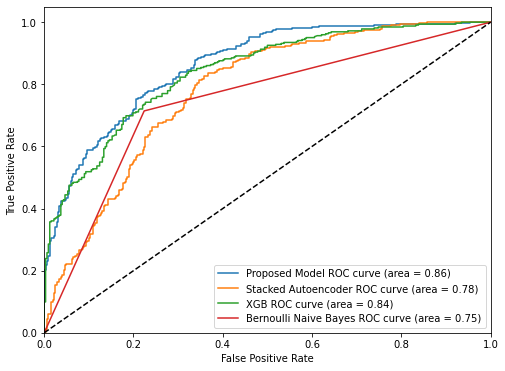

In [128]:
import matplotlib.pyplot as plt
plt.figure()
plt.figure(figsize=(8,6))
plt.plot(proposed_model_fpr2, proposed_model_tpr2, label='Proposed Model ROC curve (area = %0.2f)' % proposed_model_roc_auc2)
plt.plot(stacked_ae_fpr2, stacked_ae_tpr2, label='Stacked Autoencoder ROC curve (area = %0.2f)' % stacked_ae_roc_auc2)
plt.plot(fpr_ml, tpr_ml, label='XGB ROC curve (area = %0.2f)' % roc_auc_ml)
plt.plot(fpr_nb, tpr_nb, label='Bernoulli Naive Bayes ROC curve (area = %0.2f)' % roc_auc_nb)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Proposed autoencoder model roc_auc')
plt.legend(loc="lower right")
plt.show()

# mirror end